In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [81]:
df = pd.read_csv("grades.csv")
df = df.drop(columns=['Student ID'], errors='ignore')
df.head(10)
df.to_csv("grades.csv", index=False)

In [82]:
# Save the "Points Possible" row separately
points_possible = df.iloc[0]

# Keep only student rows (remove row 0)
df = df.iloc[1:].reset_index(drop=True)

# Convert all applicable columns to numbers
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='ignore')

# Ensure Final Score column is numeric
df['Final Score'] = pd.to_numeric(df['Final Score'], errors='coerce')

# Drop any rows missing Final Score
df = df.dropna(subset=['Final Score'])

# Convert Final Score to float
df['Final Score'] = df['Final Score'].astype(float)

/var/folders/z2/nqrvw2956m7fq60mbs3bnl5c0000gn/T/ipykernel_65092/476504855.py:9: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


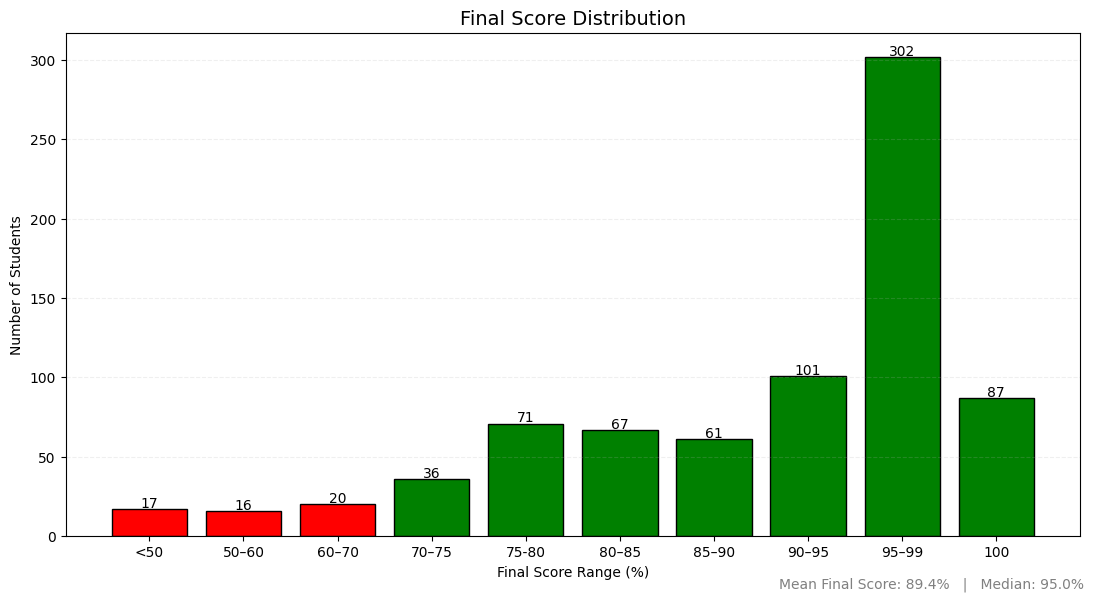

In [83]:
# Ensure 'Final Score' is numeric
final_scores = pd.to_numeric(df['Final Score'], errors='coerce')

# std
std_score = df['Final Score'].std()

# Define custom bins, isolating 100%
bins = [0, 50, 60, 70, 75, 80, 85, 90, 95, 99.99, 100]
labels = ['<50', '50–60', '60–70', '70–75','75-80', '80–85', '85–90', '90–95', '95–99', '100']

# Group scores into bins
score_bins = pd.cut(final_scores, bins=bins, labels=labels, include_lowest=True)
bin_counts = score_bins.value_counts().sort_index()

# Define red for failing, green for passing
failing_bins = ['<50', '50–60', '60–70']
bar_colors = ['red' if label in failing_bins else 'green' for label in labels]

# Plot histogram
plt.figure(figsize=(11, 6))
bars = plt.bar(bin_counts.index, bin_counts.values, color=bar_colors, edgecolor='black')

# Add bar value labels
for bar in bars:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width() / 2, height + 1, str(int(height)),
                 ha='center', fontsize=10)

# Calculate mean and median
mean_score = final_scores.mean()
median_score = final_scores.median()

# Add summary text at bottom right
plt.figtext(0.99, 0.01, f"Mean Final Score: {mean_score:.1f}%   |   Median: {median_score:.1f}%", 
            horizontalalignment='right', fontsize=10, color='gray')

# Chart formatting
plt.title('Final Score Distribution', fontsize=14)
plt.xlabel('Final Score Range (%)')
plt.ylabel('Number of Students')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.2)
plt.tight_layout()
plt.savefig("plots/Performance.png")
plt.show()

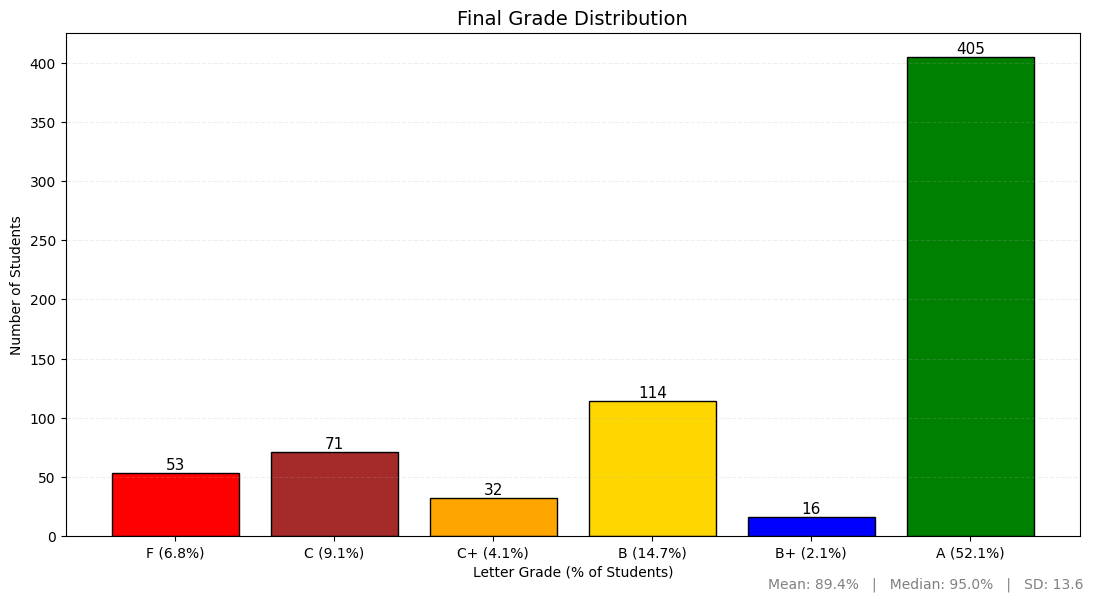

In [84]:
# Ensure final scores are numeric
final_scores = pd.to_numeric(df['Final Score'], errors='coerce')

# Grade bins and labels
grade_bins = [0, 70, 78, 80, 88, 90, 100]
grade_labels = ['F', 'C', 'C+', 'B', 'B+', 'A']

# Categorize scores
grade_categories = pd.cut(final_scores, bins=grade_bins, labels=grade_labels, include_lowest=True, right=False)
grade_counts = grade_categories.value_counts().sort_index()
total_students = len(final_scores.dropna())

# Compute % per grade and format labels
grade_percentages = [(count / total_students) * 100 for count in grade_counts]
grade_labels_with_percent = [f"{grade} ({percent:.1f}%)" for grade, percent in zip(grade_labels, grade_percentages)]

# Grade colors
grade_colors = {
    'A': 'green',
    'B+': 'blue',
    'B': 'gold',
    'C+': 'orange',
    'C': 'brown',
    'F': 'red'
}
bar_colors = [grade_colors[grade] for grade in grade_labels]

# Plot
plt.figure(figsize=(11, 6))
bars = plt.bar(grade_labels_with_percent, grade_counts.values, color=bar_colors, edgecolor='black')

# Add bar count only (percentage is already in label)
for bar in bars:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width()/2, height + 3, str(int(height)),
                 ha='center', fontsize=11)

# Stats
mean_score = final_scores.mean()
median_score = final_scores.median()
plt.figtext(
    0.99, 0.01,
    f"Mean: {mean_score:.1f}%   |   Median: {median_score:.1f}%   |   SD: {std_score:.1f}",
    horizontalalignment='right',
    fontsize=10,
    color='gray'
)

# Labels & Styling
plt.title('Final Grade Distribution', fontsize=14)
plt.xlabel('Letter Grade (% of Students)')
plt.ylabel('Number of Students')
plt.grid(axis='y', linestyle='--', alpha=0.2)
plt.tight_layout()
plt.savefig("plots/Student Performance Bins.png")
plt.show()

In [85]:
# 1. Calculate mean and standard deviation by attendance group
attendance_stats = (
    df_attendance
    .groupby('Attendance Status')['Final Score']
    .agg(['mean', 'std'])
)

# 2. Calculate overall (all students) mean and SD
overall_stats = df_attendance['Final Score'].agg(['mean', 'std'])

# 3. Add overall row to the table
attendance_stats.loc['All Students'] = overall_stats

attendance_stats

,mean,std
Attendance Status,,
Attended (30 pts),91.217984,10.392709
Did Not Attend (<30),59.305455,22.437788
All Students,89.413162,13.570658


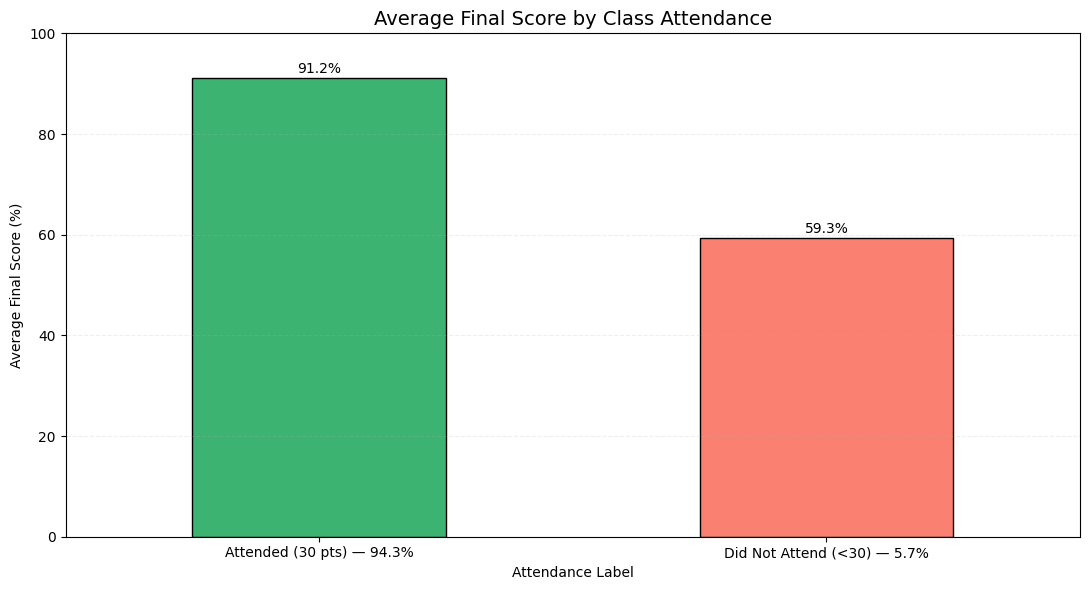

In [86]:
# Re-create the 'Attendance Status' column
df_attendance = df[['In-Class LIVE Lecture Assignment for Attendance', 'Final Score']].copy()
df_attendance = df_attendance.apply(pd.to_numeric, errors='coerce')

df_attendance['Attendance Status'] = df_attendance['In-Class LIVE Lecture Assignment for Attendance'].apply(
    lambda x: 'Attended (30 pts)' if x == 30 else 'Did Not Attend (<30)'
)

# Count percentages of each group
group_counts = df_attendance['Attendance Status'].value_counts()
total_students = group_counts.sum()
group_percentages = (group_counts / total_students * 100).round(1)

# Add percentage to label
df_attendance['Attendance Label'] = df_attendance['Attendance Status'].apply(
    lambda status: f"{status} — {group_percentages[status]}%"
)

# Calculate average final score for each label
attendance_means = df_attendance.groupby('Attendance Label')['Final Score'].mean()

# Plot as bar chart
plt.figure(figsize=(11, 6))
bars = attendance_means.plot(kind='bar', color=['mediumseagreen', 'salmon'], edgecolor='black')

# Add value labels
for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.1f}%', ha='center', fontsize=10)

# Final formatting
plt.title('Average Final Score by Class Attendance', fontsize=14)
plt.ylabel('Average Final Score (%)')
plt.xticks(rotation=0)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.2)
plt.tight_layout()
plt.savefig("plots/Class Attendance.png")
plt.show()

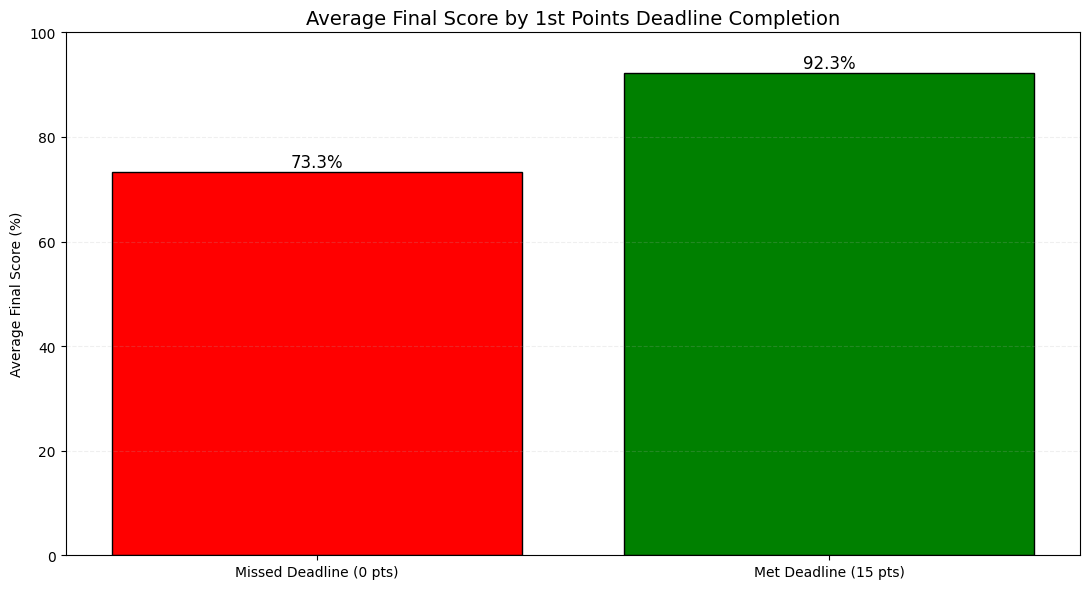

In [87]:
# Select and clean relevant columns
col_todo = '1st Points Deadline Activity Assignment'
df_deadline = df[[col_todo, 'Final Score']].copy()
df_deadline = df_deadline.apply(pd.to_numeric, errors='coerce')

# Create group labels
df_deadline['Deadline Status'] = df_deadline[col_todo].apply(
    lambda x: 'Met Deadline (15 pts)' if x == 15 else 'Missed Deadline (0 pts)'
)

# Group by status and calculate mean final score
group_means = df_deadline.groupby('Deadline Status')['Final Score'].mean().sort_values()

# Plot bar chart
plt.figure(figsize=(11, 6))
bars = plt.bar(group_means.index, group_means.values, color=['red', 'green'], edgecolor='black')

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.1f}%', ha='center', fontsize=12)

# Formatting
plt.title('Average Final Score by 1st Points Deadline Completion', fontsize=14)
plt.ylabel('Average Final Score (%)')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.2)
plt.tight_layout()
plt.savefig("plots/1stToDoPoints.png")
plt.show()

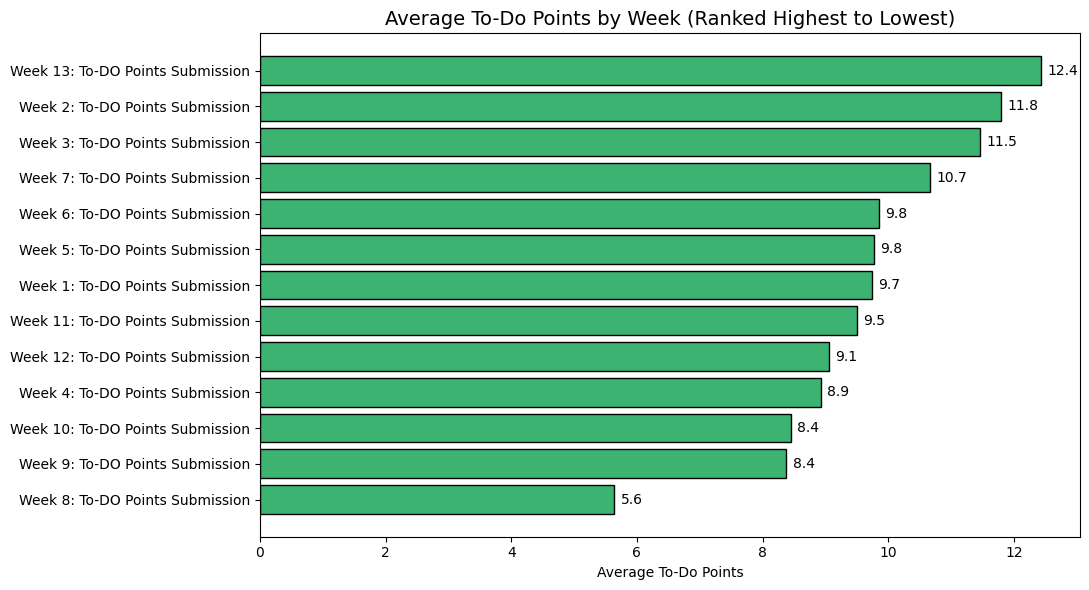

In [88]:
# Filter and clean To-Do columns from Week 1 to 13
todo_weekly_cols = [col for col in df.columns if 'Week' in col and 'To-DO Points Submission' in col]
weekly_df = df[todo_weekly_cols].apply(pd.to_numeric, errors='coerce')

# Compute average points per week
weekly_avg = weekly_df.mean().reset_index()
weekly_avg.columns = ['Week', 'Average To-Do Points']

# Extract numeric week number for optional sorting
weekly_avg['Week Number'] = weekly_avg['Week'].str.extract(r'Week (\d+)').astype(int)

# Sort by average points (descending)
weekly_avg = weekly_avg.sort_values('Average To-Do Points', ascending=False)

# Plot
plt.figure(figsize=(11, 6))
bars = plt.barh(weekly_avg['Week'], weekly_avg['Average To-Do Points'],
                color='mediumseagreen', edgecolor='black')
plt.gca().invert_yaxis()

# Add labels on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.1, bar.get_y() + bar.get_height()/2,
             f'{width:.1f}', va='center', fontsize=10)

# Titles and labels
plt.title('Average To-Do Points by Week (Ranked Highest to Lowest)', fontsize=14)
plt.xlabel('Average To-Do Points')
plt.tight_layout()
plt.savefig("plots/ToDoPoints.png")
plt.show()